In [305]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn import svm
import itertools

In [71]:
clean_data = pd.read_csv('clean_data.csv')

In [72]:
clean_data.head()

,Unnamed: 0,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,...,share_student_loan_debt,median_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,...,0.16,19441.000000,0.27,0.35,0.09,No,No,52.0,13.0,35.0
1,1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,...,0.14,13964.000000,0.33,0.39,0.05,No,No,52.0,13.0,35.0
2,2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,...,0.10,0.053697,0.26,0.38,0.19,No,No,52.0,13.0,35.0
3,3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,...,0.11,0.053697,0.31,0.40,0.12,No,No,52.0,13.0,35.0
4,4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,...,0.10,11128.000000,0.28,0.37,0.07,No,No,52.0,13.0,35.0


In [73]:
clean_data = clean_data.drop(['Unnamed: 0','median_student_loan_debt'], axis=1)

In [74]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,median_medical_debt_collections,share_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,413.0,0.16,0.27,0.35,0.09,No,No,52.0,13.0,35.0
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,604.0,0.14,0.33,0.39,0.05,No,No,52.0,13.0,35.0
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,478.0,0.10,0.26,0.38,0.19,No,No,52.0,13.0,35.0
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,582.0,0.11,0.31,0.40,0.12,No,No,52.0,13.0,35.0
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,583.0,0.10,0.28,0.37,0.07,No,No,52.0,13.0,35.0


In [75]:
clean_data.dtypes

index                                                                   object
rate_avg                                                               float64
prescriptions_per_100                                                  float64
uninsured_2015                                                         float64
uninsured_2016                                                         float64
uninsured_2017                                                         float64
population_estimate                                                    float64
Pop <5                                                                 float64
Pop 5-9                                                                float64
Pop 10-14                                                              float64
Pop 15-19                                                              float64
Pop 20-24                                                              float64
Pop 25-29                                           

In [76]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,median_medical_debt_collections,share_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,413.0,0.16,0.27,0.35,0.09,No,No,52.0,13.0,35.0
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,604.0,0.14,0.33,0.39,0.05,No,No,52.0,13.0,35.0
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,478.0,0.10,0.26,0.38,0.19,No,No,52.0,13.0,35.0
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,582.0,0.11,0.31,0.40,0.12,No,No,52.0,13.0,35.0
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,583.0,0.10,0.28,0.37,0.07,No,No,52.0,13.0,35.0


In [77]:
clean_data['rate_avg'].value_counts()


12.95    373
14.95    368
16.95    342
10.95    340
8.95     316
18.95    245
20.95    210
30.00    192
22.95    171
6.95     166
24.95    126
26.95     91
28.95     72
4.95      59
2.95      33
2.00      31
Name: rate_avg, dtype: int64

In [78]:
for i in range(len(clean_data.rate_avg)): 
    if clean_data.rate_avg[i] > 19.8: 
        clean_data.rate_avg[i] = 0
    else: 
        clean_data.rate_avg[i] = 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,median_medical_debt_collections,share_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,"Autauga County, AL",1.0,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,413.0,0.16,0.27,0.35,0.09,No,No,52.0,13.0,35.0
1,"Baldwin County, AL",0.0,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,604.0,0.14,0.33,0.39,0.05,No,No,52.0,13.0,35.0
2,"Barbour County, AL",1.0,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,478.0,0.10,0.26,0.38,0.19,No,No,52.0,13.0,35.0
3,"Bibb County, AL",1.0,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,582.0,0.11,0.31,0.40,0.12,No,No,52.0,13.0,35.0
4,"Blount County, AL",1.0,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,583.0,0.10,0.28,0.37,0.07,No,No,52.0,13.0,35.0


In [80]:
clean_data.to_pickle('clean_data_target.pkl')

In [371]:
clean_data = pd.read_pickle('clean_data_target.pkl')

In [372]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,median_medical_debt_collections,share_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,"Autauga County, AL",1.0,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,413.0,0.16,0.27,0.35,0.09,No,No,52.0,13.0,35.0
1,"Baldwin County, AL",0.0,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,604.0,0.14,0.33,0.39,0.05,No,No,52.0,13.0,35.0
2,"Barbour County, AL",1.0,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,478.0,0.10,0.26,0.38,0.19,No,No,52.0,13.0,35.0
3,"Bibb County, AL",1.0,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,582.0,0.11,0.31,0.40,0.12,No,No,52.0,13.0,35.0
4,"Blount County, AL",1.0,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,583.0,0.10,0.28,0.37,0.07,No,No,52.0,13.0,35.0


In [373]:
# clean_data = pd.get_dummies(clean_data)

## Feature Engineering

In [374]:
clean_data.columns.tolist()

['index',
 'rate_avg',
 'prescriptions_per_100',
 'uninsured_2015',
 'uninsured_2016',
 'uninsured_2017',
 'population_estimate',
 'Pop <5',
 'Pop 5-9',
 'Pop 10-14',
 'Pop 15-19',
 'Pop 20-24',
 'Pop 25-29',
 'Pop 30-34',
 'Pop 35-39',
 'Pop 40-44',
 'Pop 45-49',
 'Pop 50-54',
 'Pop 55-59',
 'Pop 60-64',
 'Pop 65-69',
 'Pop 70-74',
 'Pop 75-79',
 'Pop 80-84',
 'Pop 85+',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Est

In [380]:
clean_data['Under 30'] = clean_data.apply(lambda row: row['Pop <5'] + row['Pop 5-9'] + row['Pop 10-14'] + row['Pop 15-19'] + row['Pop 20-24'] + row['Pop 25-29'], axis=1)
clean_data['30 to 44'] = clean_data.apply(lambda row: row['Pop 30-34'] + row['Pop 35-39'] + row['Pop 40-44'], axis=1)
clean_data['45 to 64'] = clean_data.apply(lambda row: row['Pop 45-49'] + row['Pop 50-54'] + row['Pop 55-59'] + row['Pop 60-64'], axis=1)
clean_data['65 and over'] = clean_data.apply(lambda row: row['Pop 65-69'] + row['Pop 70-74'] + row['Pop 75-79'] + row['Pop 80-84'] + row['Pop 85+'], axis=1)

In [376]:
clean_data['yoy_change_uninsured'] = clean_data.apply(lambda row: (row['uninsured_2016']-row['uninsured_2015'])/row['uninsured_2015'], axis=1)

In [377]:
#https://elitedatascience.com/imbalanced-classes
df_majority = clean_data[clean_data.rate_avg==1]
df_minority = clean_data[clean_data.rate_avg==0]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=862,  
                                 random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.rate_avg.value_counts()

0.0    862
1.0    862
Name: rate_avg, dtype: int64

In [378]:
X = df_downsampled.drop(['rate_avg', 'index'], axis=1)
y = df_downsampled.rate_avg

In [379]:
X = pd.get_dummies(X)

In [238]:
cols = X.columns.tolist()
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [239]:
# for col in df_downsampled.columns:
#     df_downsampled[col] = (df_downsampled[col]-min(df_downsampled[col]))/ (max(df_downsampled[col]) - min(df_downsampled[col]))

In [240]:
X.head()

,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,Pop 15-19,Pop 20-24,...,Under 30,30 to 44,45 to 64,65 and over,yoy_change_uninsured,Medicinal_No,Medicinal_Yes,Decriminalized_No,Decriminalized_Reduced,Decriminalized_Yes
0,1.650781,0.447446,0.310240,0.639996,-0.210299,1.068447,1.945492,0.167666,0.587166,0.187248,...,0.943819,-0.025101,-0.870780,-0.637690,-0.560088,0.975928,-0.975928,-1.361729,1.852532,-0.377463
1,0.493845,-0.404435,-0.342083,-0.996933,-0.292395,0.570919,0.604184,0.083191,-0.579013,-0.078120,...,0.237549,0.812870,-0.273505,-0.617447,0.286724,0.975928,-0.975928,0.734361,-0.539802,-0.377463
2,0.461961,-0.210826,-0.361269,-1.077769,-0.351665,-0.175374,1.077587,-0.001283,-0.423522,-0.697313,...,-0.830910,-1.072565,0.456498,1.386674,-0.786406,-1.024666,1.024666,-1.361729,-0.539802,2.649265
3,-0.082345,0.157032,0.233496,0.437906,-0.262554,-0.672902,-0.421522,-0.508129,-0.345777,0.408388,...,0.020236,0.854768,-0.074413,-0.516229,0.341565,0.975928,-0.975928,-1.361729,1.852532,-0.377463
4,1.454922,-0.152743,0.022450,0.235816,-0.163200,-0.672902,0.130781,-0.170232,-0.190286,-0.299261,...,-0.378173,0.310087,0.290588,0.212543,0.839664,0.975928,-0.975928,0.734361,-0.539802,-0.377463


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Vanilla Test Model 

In [55]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

model_log = logreg.fit(X_train, y_train)
model_log

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

model_log = logreg.fit(X_train, y_train)
model_log
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [57]:
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0.0    947
 1.0    176
-1.0    170
Name: rate_avg, dtype: int64
 0.0    0.732405
 1.0    0.136118
-1.0    0.131477
Name: rate_avg, dtype: float64


In [58]:
residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0.0    326
-1.0     56
 1.0     49
Name: rate_avg, dtype: int64
 0.0    0.756381
-1.0    0.129930
 1.0    0.113689
Name: rate_avg, dtype: float64


## Testing Models

In [59]:
# Construct pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [100, 120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.9s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.7s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf_

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.0min finished


Best accuracy: 0.734

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [60]:
# Construct pipeline
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

# Set grid search params
knn_param_grid = {
    'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
}


# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_knn.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] ............................... clf__n_neighbors=4, total=   0.1s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.9s finished


In [61]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [62]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
svclassifier.score(X_test, y_test)
print_metrics(y_test, y_pred)

Precision Score: 0.7285067873303167
Recall Score: 0.7931034482758621
Accuracy Score: 0.7633410672853829
F1 Score: 0.7594339622641508


In [63]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

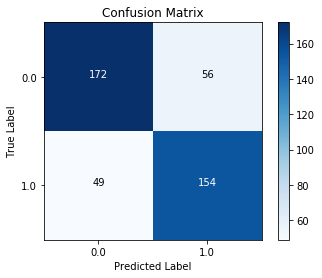

In [64]:
show_cf(y_test, y_hat_test)

In [65]:
#finding feature coefficients
coef_list = svclassifier.coef_.tolist()[0]

In [66]:
#finding most important features (helpful link to understand feature meaning with SVM https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights)
impt_list_c = []
impt_list_f = []
for i in range(len(coef_list)): 
    if abs(coef_list[i]) > 1:
        impt_coef = abs(coef_list[i])
        impt_feat = X_train.columns[i]
        impt_list_c.append(impt_coef)
        impt_list_f.append(impt_feat)
        print(impt_coef, impt_feat)

<BarContainer object of 56 artists>

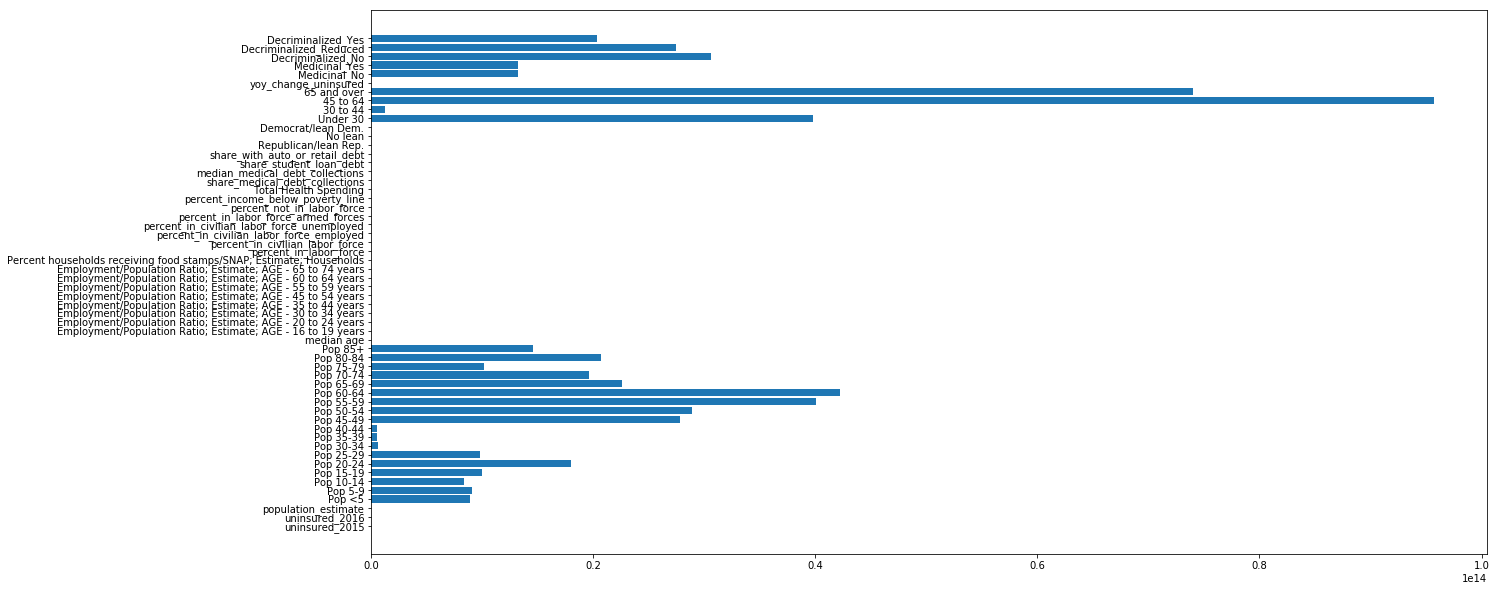

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(impt_list_f, impt_list_c)

## Linear Regression for Prescriptions

In [72]:
clean_data_lin_reg = clean_data.drop(['rate_avg'], axis=1)

In [73]:
clean_data_lin_reg.head()

,index,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,Pop 15-19,...,Medicinal,Decriminalized,Republican/lean Rep.,No lean,Democrat/lean Dem.,Under 30,30 to 44,45 to 64,65 and over,yoy_change_uninsured
0,"Autauga County, AL",129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,7.2,...,No,No,52.0,13.0,35.0,40.1,19.6,26.4,14.8,0.046875
1,"Baldwin County, AL",123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,6.1,...,No,No,52.0,13.0,35.0,35.5,18.1,27.7,19.6,0.107595
2,"Barbour County, AL",92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,5.7,...,No,No,52.0,13.0,35.0,37.7,19.3,26.5,17.4,-0.005714
3,"Bibb County, AL",97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,6.8,...,No,No,52.0,13.0,35.0,37.3,20.2,27.6,15.8,-0.006623
4,"Blount County, AL",56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,6.8,...,No,No,52.0,13.0,35.0,37.3,18.6,27.0,17.9,-0.038251


In [90]:
clean_data_lin_reg = clean_data.drop(['rate_avg', 'index'], axis=1)

y = clean_data_lin_reg.prescriptions_per_100
X = clean_data_lin_reg.drop(['prescriptions_per_100'], axis=1)

X = pd.get_dummies(X)
cols = X.columns.tolist()

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 32, test_size=0.20)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

rmse_train = np.sqrt(np.sum((y_train-y_hat_train)**2))/len(y_train)
rmse_test = np.sqrt(np.sum((y_test-y_hat_test)**2))/len(y_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 0.6752029922641722
Test Root Mean Squarred Error: 1.5909536352318705


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [91]:
coef_list = linreg.coef_.tolist()

4.745012246231118 uninsured_2015
1.9774639560067833 uninsured_2016
1.424635575326277 population_estimate
8860412782236.512 Pop <5
9029813075896.13 Pop 5-9
8324864836317.001 Pop 10-14
9939864588406.896 Pop 15-19
17973005454149.89 Pop 20-24
9779269278132.828 Pop 25-29
569061382835.04 Pop 30-34
519201989468.7312 Pop 35-39
517444036561.05396 Pop 40-44
27788111585299.027 Pop 45-49
28877046658979.234 Pop 50-54
40036243102159.766 Pop 55-59
42181371688149.62 Pop 60-64
22590300367615.887 Pop 65-69
19635330450840.484 Pop 70-74
10168456764142.635 Pop 75-79
20700052035322.844 Pop 80-84
14600963501963.055 Pop 85+
8.755859375 median age
1.1787109375 Employment/Population Ratio; Estimate; AGE - 16 to 19 years
1.6033935546875 Employment/Population Ratio; Estimate; AGE - 20 to 24 years
1.388671875 Employment/Population Ratio; Estimate; AGE - 30 to 34 years
1.1103515625 Employment/Population Ratio; Estimate; AGE - 35 to 44 years
6.491943359375 Employment/Population Ratio; Estimate; AGE - 45 to 54 years


<BarContainer object of 56 artists>

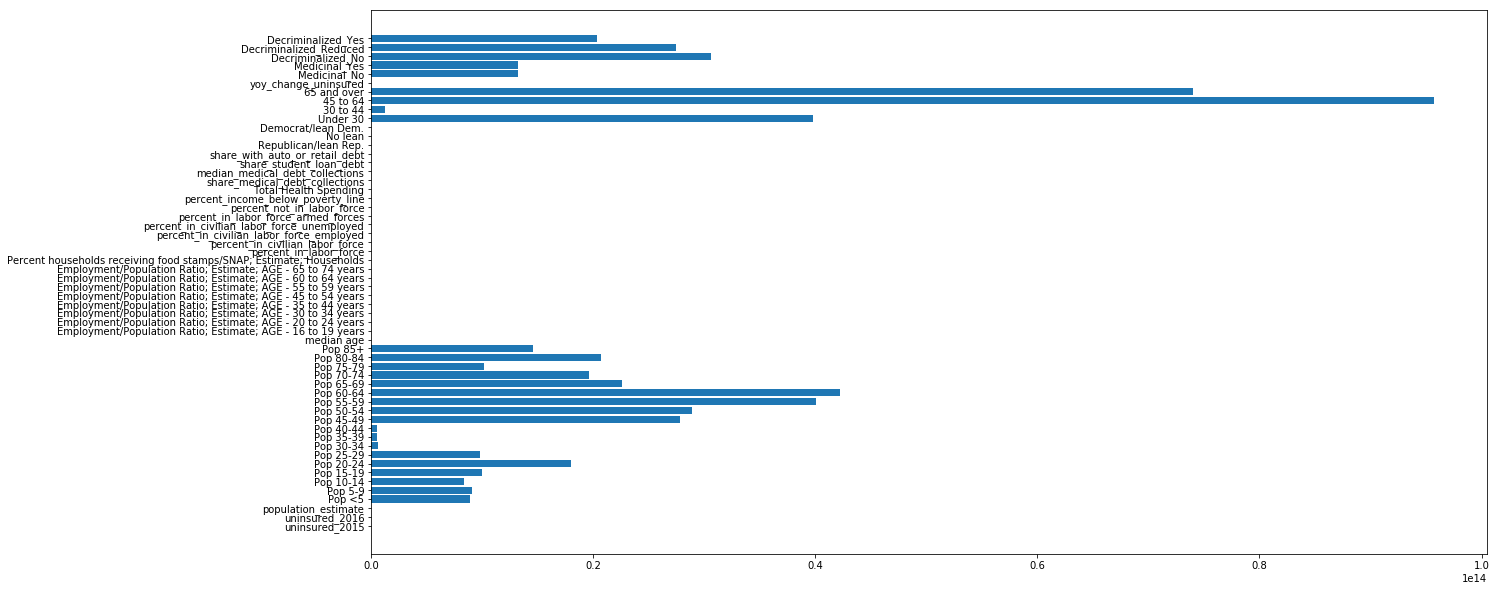

In [92]:
#finding most important features (helpful link to understand feature meaning with SVM https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights)
coef_list = linreg.coef_.tolist()

impt_list_c = []
impt_list_f = []
for i in range(len(coef_list)): 
    if abs(coef_list[i]) > 1:
        impt_coef = abs(coef_list[i])
        impt_feat = X_train.columns[i]
        impt_list_c.append(impt_coef)
        impt_list_f.append(impt_feat)
        print(impt_coef, impt_feat)
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(impt_list_f, impt_list_c)

## Adding Data

In [1231]:
clean_data = pd.read_pickle('clean_data.pkl')

In [1232]:
clean_data.columns.tolist()

['index',
 'rate_avg',
 'prescriptions_per_100',
 'uninsured_2015',
 'uninsured_2016',
 'uninsured_2017',
 'population_estimate',
 'Pop <5',
 'Pop 5-9',
 'Pop 10-14',
 'Pop 15-19',
 'Pop 20-24',
 'Pop 25-29',
 'Pop 30-34',
 'Pop 35-39',
 'Pop 40-44',
 'Pop 45-49',
 'Pop 50-54',
 'Pop 55-59',
 'Pop 60-64',
 'Pop 65-69',
 'Pop 70-74',
 'Pop 75-79',
 'Pop 80-84',
 'Pop 85+',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Est

https://apps.bea.gov/regional/downloadzip.cfm

http://www.thearda.com/Archive/Files/Downloads/RCMSCY_DL2.asp

In [1233]:
religion = pd.read_excel('data/religion.xlsx')

In [1234]:
religion.head()

,TOTCG,TOTAD,ADJAD,TOTRT,ADJRATE,MAINCG,MAINAD,MAINRT,EVANCG,EVANAD,...,ZOARCG,ZOARAD,ZOARRT,POP200,FIP,STCOD,CTYCOD,STATE,COUNTY,STATEAB
0,73,24505,30790.748170,561.127522,705.061670,12,3657,83.739782,59,18893,...,0,0,0,43671.0,1001,1,1,Alabama,Autauga,AL
1,201,66336,78855.706198,472.428159,561.590330,44,16399,116.789517,139,38670,...,0,0,0,140415.0,1003,1,3,Alabama,Baldwin,AL
2,66,11955,19893.598970,411.701908,685.088469,17,2492,85.818583,47,8935,...,0,0,0,29038.0,1005,1,5,Alabama,Barbour,AL
3,67,9656,12665.334900,463.651205,608.150144,9,513,24.632671,58,9141,...,0,0,0,20826.0,1007,1,7,Alabama,Bibb,AL
4,138,25916,28750.920555,507.917843,563.478374,26,3632,71.182189,110,21732,...,0,0,0,51024.0,1009,1,9,Alabama,Blount,AL


In [1235]:
religion_data = religion[['TOTCG', 'TOTAD', 'ADJAD', 'TOTRT', 'ADJRATE', 'COUNTY', 'STATEAB']]
religion_data.columns = ['total_num_congregations', 'total_num_adherents', 'adjusted_total_num_adherents', 'total_adherence_per_1k', 'adjusted_adherence_per_1k', 'county', 'state_abbreviation']

In [1236]:
religion_data['county'] = religion_data['county'] + ' County, ' + religion_data['state_abbreviation']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1237]:
religion_data.head()

,total_num_congregations,total_num_adherents,adjusted_total_num_adherents,total_adherence_per_1k,adjusted_adherence_per_1k,county,state_abbreviation
0,73,24505,30790.748170,561.127522,705.061670,"Autauga County, AL",AL
1,201,66336,78855.706198,472.428159,561.590330,"Baldwin County, AL",AL
2,66,11955,19893.598970,411.701908,685.088469,"Barbour County, AL",AL
3,67,9656,12665.334900,463.651205,608.150144,"Bibb County, AL",AL
4,138,25916,28750.920555,507.917843,563.478374,"Blount County, AL",AL


In [1238]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,median_student_loan_debt,share_with_auto_debt,share_with_auto_or_retail_debt,auto_retail_debt_delinquency_rate,Medicinal,Decriminalized,State Laws,Republican/lean Rep.,No lean,Democrat/lean Dem.
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,19441,0.27,0.35,0.09,No,No,View State Laws,52%,13%,35%
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,13964,0.33,0.39,0.05,No,No,View State Laws,52%,13%,35%
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,0.0536975,0.26,0.38,0.19,No,No,View State Laws,52%,13%,35%
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,0.0536975,0.31,0.4,0.12,No,No,View State Laws,52%,13%,35%
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,11128,0.28,0.37,0.07,No,No,View State Laws,52%,13%,35%


In [1239]:
clean_data = clean_data.merge(religion_data, left_on='index', right_on='county')

In [1240]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,Republican/lean Rep.,No lean,Democrat/lean Dem.,total_num_congregations,total_num_adherents,adjusted_total_num_adherents,total_adherence_per_1k,adjusted_adherence_per_1k,county,state_abbreviation
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,52%,13%,35%,73,24505,30790.748170,561.127522,705.061670,"Autauga County, AL",AL
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,52%,13%,35%,201,66336,78855.706198,472.428159,561.590330,"Baldwin County, AL",AL
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,52%,13%,35%,66,11955,19893.598970,411.701908,685.088469,"Barbour County, AL",AL
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,52%,13%,35%,67,9656,12665.334900,463.651205,608.150144,"Bibb County, AL",AL
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,52%,13%,35%,138,25916,28750.920555,507.917843,563.478374,"Blount County, AL",AL


In [1241]:
clean_data.isna().sum()

index                                                                  0
rate_avg                                                               0
prescriptions_per_100                                                  0
uninsured_2015                                                         0
uninsured_2016                                                         0
uninsured_2017                                                         0
population_estimate                                                    0
Pop <5                                                                 0
Pop 5-9                                                                0
Pop 10-14                                                              0
Pop 15-19                                                              0
Pop 20-24                                                              0
Pop 25-29                                                              0
Pop 30-34                                          

In [1242]:
clean_data.dtypes

index                                                                   object
rate_avg                                                               float64
prescriptions_per_100                                                  float64
uninsured_2015                                                         float64
uninsured_2016                                                         float64
uninsured_2017                                                         float64
population_estimate                                                    float64
Pop <5                                                                 float64
Pop 5-9                                                                float64
Pop 10-14                                                              float64
Pop 15-19                                                              float64
Pop 20-24                                                              float64
Pop 25-29                                           

In [1243]:
clean_data = clean_data.drop(['county', 'state_abbreviation'], axis=1)

In [1244]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,Decriminalized,State Laws,Republican/lean Rep.,No lean,Democrat/lean Dem.,total_num_congregations,total_num_adherents,adjusted_total_num_adherents,total_adherence_per_1k,adjusted_adherence_per_1k
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,No,View State Laws,52%,13%,35%,73,24505,30790.748170,561.127522,705.061670
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,No,View State Laws,52%,13%,35%,201,66336,78855.706198,472.428159,561.590330
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,No,View State Laws,52%,13%,35%,66,11955,19893.598970,411.701908,685.088469
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,No,View State Laws,52%,13%,35%,67,9656,12665.334900,463.651205,608.150144
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,No,View State Laws,52%,13%,35%,138,25916,28750.920555,507.917843,563.478374


In [1245]:
fentanyl_seizures = pd.read_csv('data/fentanyl_state_level.csv')

In [1246]:
fentanyl_seizures = fentanyl_seizures.loc[fentanyl_seizures['YEAR']==2016]

In [1247]:
fentanyl_seizures.head()

,STATEFP,STATE,STATEABBREVIATION,YEAR,INDICATOR,VALUE
0,1,Alabama,AL,2016,fentanyl_seize,97.0
2,2,Alaska,AK,2016,fentanyl_seize,11.0
4,4,Arizona,AZ,2016,fentanyl_seize,78.0
6,5,Arkansas,AR,2016,fentanyl_seize,58.0
8,6,California,CA,2016,fentanyl_seize,215.0


In [1248]:
fentanyl_seizures.columns = ['statefp', 'state', 'state_abbrev', 'year', 'indicator', 'fentanyl_seizures']

In [1249]:
fentanyl_seizures.isna().sum()

statefp              0
state                0
state_abbrev         0
year                 0
indicator            0
fentanyl_seizures    1
dtype: int64

In [1250]:
fentanyl_seizures['fentanyl_seizures'] = fentanyl_seizures['fentanyl_seizures'].fillna(fentanyl_seizures['fentanyl_seizures'].mean())

In [1251]:
fentanyl_seizures.isna().sum()

statefp              0
state                0
state_abbrev         0
year                 0
indicator            0
fentanyl_seizures    0
dtype: int64

In [1252]:
clean_data['abbrev'] = clean_data['index'].str.slice(-2)

In [1253]:
clean_data.shape

(2959, 65)

In [1254]:
clean_data = clean_data.merge(fentanyl_seizures, left_on='abbrev', right_on='state_abbrev')

In [1255]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,adjusted_total_num_adherents,total_adherence_per_1k,adjusted_adherence_per_1k,abbrev,statefp,state,state_abbrev,year,indicator,fentanyl_seizures
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,30790.748170,561.127522,705.061670,AL,1,Alabama,AL,2016,fentanyl_seize,97.0
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,78855.706198,472.428159,561.590330,AL,1,Alabama,AL,2016,fentanyl_seize,97.0
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,19893.598970,411.701908,685.088469,AL,1,Alabama,AL,2016,fentanyl_seize,97.0
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,12665.334900,463.651205,608.150144,AL,1,Alabama,AL,2016,fentanyl_seize,97.0
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,28750.920555,507.917843,563.478374,AL,1,Alabama,AL,2016,fentanyl_seize,97.0


In [1256]:
clean_data.shape

(2959, 71)

In [1257]:
non_med = pd.read_csv('data/non_med_use.csv')

In [1258]:
non_med.isna().sum()

STATEFP               0
COUNTYFP              0
YEAR                  0
INDICATOR             0
VALUE                79
STATE                 0
STATEABBREVIATION     0
COUNTY                0
dtype: int64

In [1259]:
non_med.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,STATE,STATEABBREVIATION,COUNTY
0,1,1,2014,nonmedpain,5.12,Alabama,AL,Autauga County
1,1,3,2014,nonmedpain,5.27,Alabama,AL,Baldwin County
2,1,5,2014,nonmedpain,5.27,Alabama,AL,Barbour County
3,1,7,2014,nonmedpain,5.62,Alabama,AL,Bibb County
4,1,9,2014,nonmedpain,5.62,Alabama,AL,Blount County


In [1260]:
non_med['county_state'] = non_med['COUNTY'] + ', ' + non_med['STATEABBREVIATION']

In [1261]:
non_med.head()

,STATEFP,COUNTYFP,YEAR,INDICATOR,VALUE,STATE,STATEABBREVIATION,COUNTY,county_state
0,1,1,2014,nonmedpain,5.12,Alabama,AL,Autauga County,"Autauga County, AL"
1,1,3,2014,nonmedpain,5.27,Alabama,AL,Baldwin County,"Baldwin County, AL"
2,1,5,2014,nonmedpain,5.27,Alabama,AL,Barbour County,"Barbour County, AL"
3,1,7,2014,nonmedpain,5.62,Alabama,AL,Bibb County,"Bibb County, AL"
4,1,9,2014,nonmedpain,5.62,Alabama,AL,Blount County,"Blount County, AL"


In [1262]:
non_med.columns = ['statefp', 'countyfp', 'year', 'indicator', 'non_med', 'state', 'state_abbrev', 'county', 'county_state']

In [1263]:
clean_data = clean_data.merge(non_med, left_on='index', right_on='county_state')

In [1264]:
clean_data.shape

(2954, 80)

In [1265]:
family_status = pd.read_csv('data/family_status.csv', encoding='latin-1', header=1)

family_status.columns.tolist()
family_status = family_status[['Geography', 'Total; Estimate; Total households', 'Married-couple family household; Estimate; Total households', 'Male householder, no wife present, family household; Estimate; Total households', 'Female householder, no husband present, family household; Estimate; Total households', 'Total; Estimate; HOUSING TENURE - Renter-occupied housing units', 'Nonfamily household; Estimate; Total households']]

family_status.head()

,Geography,Total; Estimate; Total households,Married-couple family household; Estimate; Total households,"Male householder, no wife present, family household; Estimate; Total households","Female householder, no husband present, family household; Estimate; Total households",Total; Estimate; HOUSING TENURE - Renter-occupied housing units,Nonfamily household; Estimate; Total households
0,"Autauga County, Alabama",20800,11735,570,2348,26.8,6147
1,"Baldwin County, Alabama",75149,40093,2622,7475,28.3,24959
2,"Barbour County, Alabama",9122,3968,285,1715,36.1,3154
3,"Bibb County, Alabama",7048,3928,310,1034,27.4,1776
4,"Blount County, Alabama",20619,12314,1082,2043,21.2,5180


In [1266]:
family_status['state'] = family_status['Geography'].apply(lambda x: x.split(', ')[1])

In [1267]:
family_status.head()

,Geography,Total; Estimate; Total households,Married-couple family household; Estimate; Total households,"Male householder, no wife present, family household; Estimate; Total households","Female householder, no husband present, family household; Estimate; Total households",Total; Estimate; HOUSING TENURE - Renter-occupied housing units,Nonfamily household; Estimate; Total households,state
0,"Autauga County, Alabama",20800,11735,570,2348,26.8,6147,Alabama
1,"Baldwin County, Alabama",75149,40093,2622,7475,28.3,24959,Alabama
2,"Barbour County, Alabama",9122,3968,285,1715,36.1,3154,Alabama
3,"Bibb County, Alabama",7048,3928,310,1034,27.4,1776,Alabama
4,"Blount County, Alabama",20619,12314,1082,2043,21.2,5180,Alabama


In [1268]:
states_abbreviations = pd.read_html('https://developers.google.com/public-data/docs/canonical/states_csv', header=0)[0]
states_abbreviations.columns = ['abbreviation', 'latitude', 'longitude', 'state']
states_abbreviations.head()

,abbreviation,latitude,longitude,state
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [1269]:
family_status = pd.merge(family_status, states_abbreviations, on='state')

In [1270]:
family_status['county_state'] = family_status['Geography'].apply(lambda x: x.split(', ')[0]) + ', ' + family_status['abbreviation']

In [1271]:
family_status.head()

,Geography,Total; Estimate; Total households,Married-couple family household; Estimate; Total households,"Male householder, no wife present, family household; Estimate; Total households","Female householder, no husband present, family household; Estimate; Total households",Total; Estimate; HOUSING TENURE - Renter-occupied housing units,Nonfamily household; Estimate; Total households,state,abbreviation,latitude,longitude,county_state
0,"Autauga County, Alabama",20800,11735,570,2348,26.8,6147,Alabama,AL,32.318231,-86.902298,"Autauga County, AL"
1,"Baldwin County, Alabama",75149,40093,2622,7475,28.3,24959,Alabama,AL,32.318231,-86.902298,"Baldwin County, AL"
2,"Barbour County, Alabama",9122,3968,285,1715,36.1,3154,Alabama,AL,32.318231,-86.902298,"Barbour County, AL"
3,"Bibb County, Alabama",7048,3928,310,1034,27.4,1776,Alabama,AL,32.318231,-86.902298,"Bibb County, AL"
4,"Blount County, Alabama",20619,12314,1082,2043,21.2,5180,Alabama,AL,32.318231,-86.902298,"Blount County, AL"


In [1272]:
family_status.isna().sum()

Geography                                                                               0
Total; Estimate; Total households                                                       0
Married-couple family household; Estimate; Total households                             0
Male householder, no wife present, family household; Estimate; Total households         0
Female householder, no husband present, family household; Estimate; Total households    0
Total; Estimate; HOUSING TENURE - Renter-occupied housing units                         0
Nonfamily household; Estimate; Total households                                         0
state                                                                                   0
abbreviation                                                                            0
latitude                                                                                0
longitude                                                                               0
county_sta

In [1273]:
clean_data = clean_data.merge(family_status, left_on='index', right_on='county_state')

In [1274]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,Married-couple family household; Estimate; Total households,"Male householder, no wife present, family household; Estimate; Total households","Female householder, no husband present, family household; Estimate; Total households",Total; Estimate; HOUSING TENURE - Renter-occupied housing units,Nonfamily household; Estimate; Total households,state,abbreviation,latitude,longitude,county_state_y
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,11735,570,2348,26.8,6147,Alabama,AL,32.318231,-86.902298,"Autauga County, AL"
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,40093,2622,7475,28.3,24959,Alabama,AL,32.318231,-86.902298,"Baldwin County, AL"
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,3968,285,1715,36.1,3154,Alabama,AL,32.318231,-86.902298,"Barbour County, AL"
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,3928,310,1034,27.4,1776,Alabama,AL,32.318231,-86.902298,"Bibb County, AL"
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,12314,1082,2043,21.2,5180,Alabama,AL,32.318231,-86.902298,"Blount County, AL"


In [1275]:
clean_data['hh_to_pop'] = clean_data['Total; Estimate; Total households'] / clean_data['population_estimate']
clean_data['married_to_total_hh'] = clean_data['Married-couple family household; Estimate; Total households'] / clean_data['Total; Estimate; Total households'] 
clean_data['single_male_to_total_hh'] = clean_data['Male householder, no wife present, family household; Estimate; Total households'] / clean_data['Total; Estimate; Total households'] 
clean_data['single_female_to_total_hh'] = clean_data['Female householder, no husband present, family household; Estimate; Total households'] / clean_data['Total; Estimate; Total households']  
clean_data['renter_to_total_hh'] = clean_data['Total; Estimate; HOUSING TENURE - Renter-occupied housing units'] /clean_data['Total; Estimate; Total households'] 
clean_data['nonfamily_to_total_hh'] = clean_data['Nonfamily household; Estimate; Total households'] /clean_data['Total; Estimate; Total households'] 

In [1276]:
clean_data.head()

,index,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,...,abbreviation,latitude,longitude,county_state_y,hh_to_pop,married_to_total_hh,single_male_to_total_hh,single_female_to_total_hh,renter_to_total_hh,nonfamily_to_total_hh
0,"Autauga County, AL",10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,...,AL,32.318231,-86.902298,"Autauga County, AL",0.377845,0.564183,0.027404,0.112885,0.001288,0.295529
1,"Baldwin County, AL",20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,...,AL,32.318231,-86.902298,"Baldwin County, AL",0.376668,0.533513,0.034891,0.099469,0.000377,0.332127
2,"Barbour County, AL",6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,...,AL,32.318231,-86.902298,"Barbour County, AL",0.342752,0.434992,0.031243,0.188007,0.003957,0.345758
3,"Bibb County, AL",16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,...,AL,32.318231,-86.902298,"Bibb County, AL",0.312245,0.557321,0.043984,0.146708,0.003888,0.251986
4,"Blount County, AL",16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,...,AL,32.318231,-86.902298,"Blount County, AL",0.357324,0.597216,0.052476,0.099083,0.001028,0.251225


In [1277]:
clean_data.shape

(2953, 98)

In [1278]:
urbanization_data = pd.read_csv('data/urbanization_data.csv', encoding='latin-1', header=1)

In [1279]:
urbanization_data['split'] = urbanization_data['Geographic area'].apply(lambda x: x.split('-'))

In [1280]:
urbanization_data['split'] = urbanization_data['split'].apply(lambda x: x[1] if len(x)>1 else None)

In [1281]:
urbanization_data.head()

,Id,Id2,Geography,Target Geo Id,Target Geo Id2,Geographic area,Geographic area.1,Population,Housing units,Area in square miles - Total area,Area in square miles - Water area,Area in square miles - Land area,Density per square mile of land area - Population,Density per square mile of land area - Housing units,split
0,0100000US,NaN,United States,0100000US,NaN,United States,United States,308745538(r38234),131704730(r15031),3796742.23,264836.79,3531905.43,87.4,37.3,None
1,0100000US,NaN,United States,0400000US01,1.0,United States - Alabama,Alabama,4779736(r38235),2171853(r15032),52420.07,1774.74,50645.33,94.4,42.9,Alabama
2,0100000US,NaN,United States,0500000US01001,1001.0,United States - Alabama - Autauga County,Autauga County,54571,22135,604.39,9.95,594.44,91.8,37.2,Alabama
3,0100000US,NaN,United States,0500000US01003,1003.0,United States - Alabama - Baldwin County,Baldwin County,182265,104061,2027.31,437.53,1589.78,114.6,65.5,Alabama
4,0100000US,NaN,United States,0500000US01005,1005.0,United States - Alabama - Barbour County,Barbour County,27457,11829(r15033),904.52,19.64,884.88,31.0,13.4,Alabama


In [1282]:
urbanization_data['split'] = urbanization_data['split'].apply(lambda x: x.replace(' ','') if x != None else None)

In [1283]:
urbanization_data = urbanization_data.merge(states_abbreviations, left_on='split', right_on='state', how='outer')

In [1284]:
urbanization_data['county_state'] = urbanization_data['Geographic area.1'] + ', ' + urbanization_data['abbreviation']

In [1285]:
urbanization_data = urbanization_data[['county_state', 'Density per square mile of land area - Population', 'Density per square mile of land area - Housing units']]

In [1286]:
clean_data = clean_data.merge(urbanization_data, left_on='index', right_on='county_state')

In [1287]:
clean_data.isna().sum()

index                                                                                   0
rate_avg                                                                                0
prescriptions_per_100                                                                   0
uninsured_2015                                                                          0
uninsured_2016                                                                          0
uninsured_2017                                                                          0
population_estimate                                                                     0
Pop <5                                                                                  0
Pop 5-9                                                                                 0
Pop 10-14                                                                               0
Pop 15-19                                                                               0
Pop 20-24 

In [1288]:
median_income = pd.read_csv('data/median_income.csv', encoding='latin-1', header=1)

In [1289]:
median_income = median_income[['Geography', 'Total; Estimate; Households']]
median_income['state'] = median_income['Geography'].apply(lambda x: x.split(',')[1].replace(' ', ''))
median_income = pd.merge(median_income, states_abbreviations, on='state')
median_income['county_state'] = median_income['Geography'].apply(lambda x: x.split(',')[0]) + ', ' + median_income['abbreviation']

In [1290]:
median_income = median_income[['Total; Estimate; Households', 'county_state']]
median_income.columns = ['median income', 'county_state']

In [1291]:
clean_data = clean_data.merge(median_income, left_on='index', right_on='county_state')

In [1292]:
race = pd.read_csv('data/race.csv', encoding='latin-1', header=1)

In [1293]:
race = race[['Geography', 'Estimate; Total: - White alone', 'Estimate; Total: - Black or African American alone', 'Estimate; Total: - American Indian and Alaska Native alone', 'Estimate; Total: - Asian alone', 'Estimate; Total: - Native Hawaiian and Other Pacific Islander alone', 'Estimate; Total: - Some other race alone', 'Estimate; Total: - Two or more races:']]


In [1294]:
race.columns = ['geography', 'pop_white', 'pop_black', 'pop_native_american', 'pop_asian', 'pop_pac_islander', 'pop_ohter race', 'pop_two_more_races']

In [1295]:
race['state'] = race['geography'].apply(lambda x: x.split(',')[1].replace(' ', ''))
race = pd.merge(race, states_abbreviations, on='state')
race['county_state'] = race['geography'].apply(lambda x: x.split(',')[0]) + ', ' + race['abbreviation']

In [1296]:
clean_data = clean_data.merge(race, left_on='index', right_on='county_state')

In [1297]:
clean_data['non_med'] = clean_data['non_med'].fillna(clean_data['non_med'].mean())

In [1298]:
clean_data.columns.tolist()

['index',
 'rate_avg',
 'prescriptions_per_100',
 'uninsured_2015',
 'uninsured_2016',
 'uninsured_2017',
 'population_estimate',
 'Pop <5',
 'Pop 5-9',
 'Pop 10-14',
 'Pop 15-19',
 'Pop 20-24',
 'Pop 25-29',
 'Pop 30-34',
 'Pop 35-39',
 'Pop 40-44',
 'Pop 45-49',
 'Pop 50-54',
 'Pop 55-59',
 'Pop 60-64',
 'Pop 65-69',
 'Pop 70-74',
 'Pop 75-79',
 'Pop 80-84',
 'Pop 85+',
 'median age',
 'Employment/Population Ratio; Estimate; AGE - 16 to 19 years',
 'Employment/Population Ratio; Estimate; AGE - 20 to 24 years',
 'Employment/Population Ratio; Estimate; AGE - 25 to 29 years',
 'Employment/Population Ratio; Estimate; AGE - 30 to 34 years',
 'Employment/Population Ratio; Estimate; AGE - 35 to 44 years',
 'Employment/Population Ratio; Estimate; AGE - 45 to 54 years',
 'Employment/Population Ratio; Estimate; AGE - 55 to 59 years',
 'Employment/Population Ratio; Estimate; AGE - 60 to 64 years',
 'Employment/Population Ratio; Estimate; AGE - 65 to 74 years',
 'Employment/Population Ratio; Est

In [1299]:
clean_data['prop_white'] = clean_data['pop_white'] / clean_data['population_estimate']
clean_data['prop_black'] = clean_data['pop_black'] / clean_data['population_estimate']
clean_data['prop_native_american'] = clean_data['pop_native_american'] / clean_data['population_estimate']
clean_data['pop_asian'] = clean_data['pop_asian'] / clean_data['population_estimate']
clean_data['pop_pac_islander'] = clean_data['pop_pac_islander'] / clean_data['population_estimate']
clean_data['pop_other_race'] = clean_data['pop_ohter race'] / clean_data['population_estimate']
clean_data['pop_two_more_races'] = clean_data['pop_two_more_races'] / clean_data['population_estimate']

In [1300]:
clean_data = clean_data.drop(['index', 'abbrev', 'statefp_x', 'state_x', 'state_abbrev_x', 'year_x', 'indicator_x', 'statefp_y', 'countyfp', 'year_y', 'indicator_y', 'state_y', 'state_abbrev_y', 'county', 'county_state_x', 'Geography', 'Total; Estimate; Total households', 'Married-couple family household; Estimate; Total households', 'Male householder, no wife present, family household; Estimate; Total households', 'Female householder, no husband present, family household; Estimate; Total households', 'Total; Estimate; HOUSING TENURE - Renter-occupied housing units', 'Nonfamily household; Estimate; Total households', 'state_x', 'abbreviation_x', 'latitude_x', 'longitude_x', 'county_state_y', 'county_state_x', 'county_state_y', 'geography', 'state_y', 'abbreviation_y', 'latitude_y', 'longitude_y'], axis=1)

In [1301]:
clean_data['prop_under_18'] = (clean_data['Pop <5'] + clean_data['Pop 5-9'] + clean_data['Pop 10-14'] + clean_data['Pop 15-19']) / clean_data['population_estimate']
clean_data['prop_under_40'] = (clean_data['Pop 20-24'] + clean_data['Pop 25-29'] + clean_data['Pop 30-34'] + clean_data['Pop 35-39']) / clean_data['population_estimate']
clean_data['prop_under_55'] = (clean_data['Pop 40-44'] + clean_data['Pop 45-49'] + clean_data['Pop 50-54']) / clean_data['population_estimate']
clean_data['prop_under_70'] = (clean_data['Pop 60-64'] + clean_data['Pop 65-69'] + clean_data['Pop 70-74'] + clean_data['Pop 35-39']) / clean_data['population_estimate']
clean_data['prop_under_80'] = (clean_data['Pop 70-74'] + clean_data['Pop 75-79']) / clean_data['population_estimate']
clean_data['prop_80_and_above'] = (clean_data['Pop 80-84'] + clean_data['Pop 85+']) / clean_data['population_estimate']

In [1302]:
clean_data.head()

,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,Pop <5,Pop 5-9,Pop 10-14,Pop 15-19,...,prop_white,prop_black,prop_native_american,pop_other_race,prop_under_18,prop_under_40,prop_under_55,prop_under_70,prop_under_80,prop_80_and_above
0,10.95,129.6,0.128,0.134,0.110,55049.0,5.8,6.9,7.7,7.2,...,0.768606,0.185217,0.004105,0.013879,0.000501,0.000463,0.000387,0.000376,0.000116,0.000069
1,20.95,123.8,0.158,0.175,0.161,199510.0,5.7,6.3,6.3,6.1,...,0.864323,0.093198,0.006792,0.008852,0.000122,0.000114,0.000102,0.000122,0.000040,0.000026
2,6.95,92.7,0.175,0.174,0.153,26614.0,5.5,6.4,6.0,5.7,...,0.467047,0.479297,0.001728,0.041294,0.000887,0.001052,0.000721,0.000864,0.000278,0.000169
3,16.95,97.2,0.151,0.150,0.136,22572.0,5.1,5.2,6.7,6.8,...,0.769537,0.212121,0.003589,0.000354,0.001054,0.001147,0.001028,0.000908,0.000301,0.000168
4,16.95,56.9,0.183,0.176,0.165,57704.0,6.1,6.6,6.8,6.8,...,0.954405,0.015683,0.003483,0.008682,0.000456,0.000388,0.000369,0.000392,0.000130,0.000076


In [1304]:
clean_data = clean_data.drop(['Pop <5', 'Pop 5-9', 'Pop 10-14', 'Pop 15-19', 'Pop 20-24', 'Pop 25-29', 'Pop 30-34', 'Pop 35-39', 'Pop 40-44', 'Pop 45-49', 'Pop 50-54', 'Pop 55-59', 'Pop 60-64', 'Pop 65-69', 'Pop 70-74', 'Pop 75-79', 'Pop 80-84', 'Pop 85+'], axis=1)


In [1306]:
clean_data.head()

,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,...,prop_white,prop_black,prop_native_american,pop_other_race,prop_under_18,prop_under_40,prop_under_55,prop_under_70,prop_under_80,prop_80_and_above
0,10.95,129.6,0.128,0.134,0.110,55049.0,37.8,21.7,71.2,77.6,...,0.768606,0.185217,0.004105,0.013879,0.000501,0.000463,0.000387,0.000376,0.000116,0.000069
1,20.95,123.8,0.158,0.175,0.161,199510.0,42.3,33.9,71.7,69.7,...,0.864323,0.093198,0.006792,0.008852,0.000122,0.000114,0.000102,0.000122,0.000040,0.000026
2,6.95,92.7,0.175,0.174,0.153,26614.0,38.7,14.6,46.7,45.7,...,0.467047,0.479297,0.001728,0.041294,0.000887,0.001052,0.000721,0.000864,0.000278,0.000169
3,16.95,97.2,0.151,0.150,0.136,22572.0,40.2,12.9,42.7,48.6,...,0.769537,0.212121,0.003589,0.000354,0.001054,0.001147,0.001028,0.000908,0.000301,0.000168
4,16.95,56.9,0.183,0.176,0.165,57704.0,40.8,19,53.3,64.8,...,0.954405,0.015683,0.003483,0.008682,0.000456,0.000388,0.000369,0.000392,0.000130,0.000076


## Classification with Additional Data

In [1307]:
clean_data['rate_avg'] = clean_data['rate_avg'].apply(lambda x: 0 if x > 19.8 else 1)

In [1308]:
clean_data['Total Health Spending'] = clean_data['Total Health Spending'].apply(lambda x: x.replace('$',''))

In [1309]:
clean_data['Employment/Population Ratio; Estimate; AGE - 16 to 19 years'] = clean_data['Employment/Population Ratio; Estimate; AGE - 16 to 19 years'].astype(float)
clean_data['Employment/Population Ratio; Estimate; AGE - 25 to 29 years'] = clean_data['Employment/Population Ratio; Estimate; AGE - 25 to 29 years'].astype(float)
clean_data['Employment/Population Ratio; Estimate; AGE - 30 to 34 years'] = clean_data['Employment/Population Ratio; Estimate; AGE - 30 to 34 years'].astype(float)
clean_data['Employment/Population Ratio; Estimate; AGE - 75 years and over'] = clean_data['Employment/Population Ratio; Estimate; AGE - 75 years and over'].astype(float)
clean_data['percent_income_below_poverty_line'] = clean_data['percent_income_below_poverty_line'].astype(float)
clean_data['Total Health Spending'] = clean_data['Total Health Spending'].astype(float)
clean_data['SMHA Expenditures Per Capita'] = clean_data['SMHA Expenditures Per Capita'].astype(float)
clean_data['share_medical_debt_collections'] = clean_data['share_medical_debt_collections'].astype(float)
clean_data['median_medical_debt_collections'] = clean_data['median_medical_debt_collections'].astype(float)
clean_data['share_student_loan_debt'] = clean_data['share_student_loan_debt'].astype(float)
clean_data['median_student_loan_debt'] = clean_data['median_student_loan_debt'].astype(float)
clean_data['share_with_auto_debt'] = clean_data['share_with_auto_debt'].astype(float)
clean_data['share_with_auto_or_retail_debt'] = clean_data['share_with_auto_or_retail_debt'].astype(float)
clean_data['auto_retail_debt_delinquency_rate'] = clean_data['auto_retail_debt_delinquency_rate'].astype(float)

In [1310]:
clean_data['median_student_loan_debt'] = clean_data['median_student_loan_debt'].fillna(clean_data['median_student_loan_debt'].mean())

In [1311]:
df_majority = clean_data[clean_data.rate_avg==1]
df_minority = clean_data[clean_data.rate_avg==0]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=684,  
                                 random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_downsampled.rate_avg.value_counts()

X = df_downsampled.drop(['rate_avg', 'county_state'], axis=1)
y = df_downsampled.rate_avg

X = pd.get_dummies(X)

cols = X.columns.tolist()
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

model_log = logreg.fit(X_train, y_train)
model_log
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    845
 1     96
-1     85
Name: rate_avg, dtype: int64
 0    0.823587
 1    0.093567
-1    0.082846
Name: rate_avg, dtype: float64
 0    271
 1     39
-1     32
Name: rate_avg, dtype: int64
 0    0.792398
 1    0.114035
-1    0.093567
Name: rate_avg, dtype: float64


In [1312]:
# Construct pipeline
pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [100, 120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_spli

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf_

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.9min finished


Best accuracy: 0.782

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 120}


In [1227]:
# Construct pipeline
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

# Set grid search params
knn_param_grid = {
    'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
}


# Construct grid search
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_knn.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_knn.best_score_)

# Best params
print('\nBest params:\n', gs_knn.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.9s finished


In [1228]:
# Construct pipeline
pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
#  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   15.9s finished


In [1229]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()

adaboost_clf.fit(X_train, y_train)
adaboost_train_preds = adaboost_clf.predict(X_train)
adaboost_test_preds = adaboost_clf.predict(X_test)

adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

print('AdaBoosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

AdaBoosting
Training Accuracy: 0.8665 		 Testing Accuracy: 0.7749
F1 Score: 0.7748538011695906


In [1230]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

gb_clf.fit(X_train, y_train)
gb_train_preds = gb_clf.predict(X_train)
gb_test_preds = gb_clf.predict(X_test)

gb_train_score = accuracy_score(y_train, gb_train_preds)
gb_test_score = accuracy_score(y_test, gb_test_preds)

print('Gradient Boosting')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

Gradient Boosting
Training Accuracy: 0.8655 		 Testing Accuracy: 0.769
F1 Score: 0.7690058479532165


In [1131]:
import tpot
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)


#we ran the classifier, which will tell us the best model to use.
tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.7787639119109636
Generation 2 - Current best internal CV score: 0.795354013734312
Generation 3 - Current best internal CV score: 0.795354013734312
Generation 4 - Current best internal CV score: 0.795354013734312
Generation 5 - Current best internal CV score: 0.795354013734312

Best pipeline: LogisticRegression(input_matrix, C=0.01, dual=False, penalty=l2)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=5,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=20,
        random_state=None, scoring=None, subsample=1.0, use_dask=False,
        verbosity=2, warm_start=False)

## Linear Regression with Additional Data

In [1135]:
clean_data_lin_reg = clean_data.drop(['rate_avg'], axis=1)
cols = clean_data_lin_reg.columns.tolist()

y = clean_data_lin_reg.prescriptions_per_100
X = clean_data_lin_reg.drop(['prescriptions_per_100'], axis=1)

X = pd.get_dummies(X)

scaler = preprocessing.StandardScaler()
clean_data_lin_reg = scaler.fit_transform(X)
clean_data_lin_reg = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 32, test_size=0.20)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

rmse_train = np.sqrt(np.sum((y_train-y_hat_train)**2))/len(y_train)
rmse_test = np.sqrt(np.sum((y_test-y_hat_test)**2))/len(y_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Train Root Mean Squarred Error: 7.386946003533354e-09
Test Root Mean Squarred Error: 1.4523945222907706


12.406885400743313 uninsured_2015
57.91898431523063 uninsured_2016
36.62178491653075 uninsured_2017
4.448914046068305 Pop <5
2.531548640179074 Pop 5-9
3.6469699822926067 Pop 10-14
1.0386578309032857 Pop 15-19
2.120042384064006 Pop 20-24
2.9423450142152565 Pop 30-34
1.5829966226818641 Pop 35-39
2.202019797565157 Pop 45-49
2.184126876859689 Pop 50-54
1.2098457348470957 Pop 70-74
3.6553038618074685 Pop 85+
1.0154162037024612 median age
15.767256492663002 percent_in_civilian_labor_force
13.264420829591598 percent_in_civilian_labor_force_employed
13.873737360181043 percent_in_civilian_labor_force_unemployed
1.4488458801529702 percent_in_labor_force_armed_forces
29.52922366964436 share_medical_debt_collections
63.81394946169585 share_student_loan_debt
3.7670495744722703 share_with_auto_debt
8.083806156351761 share_with_auto_or_retail_debt
8.231703516705707 auto_retail_debt_delinquency_rate
6.8666009957907646 non_med
62.38264370042447 hh_to_pop
45.39141046748784 married_to_total_hh
6.99225502

30.199550191653366 county_state_Guthrie County, IA
14.639470424001757 county_state_Gwinnett County, GA
9.459004119807435 county_state_Habersham County, GA
2.640297282709808 county_state_Hale County, AL
3.0299946866491174 county_state_Hale County, TX
5.105484011092793 county_state_Halifax County, VA
11.066465265106691 county_state_Hall County, GA
44.07074832627116 county_state_Hall County, TX
30.72722425294938 county_state_Hamilton County, FL
29.2352319439844 county_state_Hamilton County, IA
73.91595686022173 county_state_Hamilton County, IL
15.612040054363424 county_state_Hamilton County, IN
14.282727027319295 county_state_Hamilton County, KS
3.754299691791979 county_state_Hamilton County, OH
2.496647973000614 county_state_Hamilton County, TN
31.13844100227495 county_state_Hamilton County, TX
11.198535535779095 county_state_Hampshire County, MA
7.676504653836098 county_state_Hancock County, GA
37.21583509487825 county_state_Hancock County, IA
22.859346524311768 county_state_Hancock Cou

10.990946527526884 county_state_Marshall County, IL
24.512489251613474 county_state_Marshall County, KS
14.930643715360402 county_state_Marshall County, MN
45.578436671115995 county_state_Marshall County, MS
14.94664681660734 county_state_Marshall County, OK
25.654103534150448 county_state_Marshall County, TN
21.693614090377032 county_state_Martin County, IN
11.96253914205854 county_state_Martin County, KY
2.5407419084611655 county_state_Martin County, TX
3.919874178299952 county_state_Mason County, IL
6.794087717778774 county_state_Mason County, KY
28.388250888798755 county_state_Mason County, MI
1.7084625185283961 county_state_Mason County, TX
6.160396552798011 county_state_Mason County, WA
71.40719948302694 county_state_Massac County, IL
30.223011812165826 county_state_Matagorda County, TX
13.374682318131923 county_state_Mathews County, VA
8.28878455200573 county_state_Maui County, HI
9.97478377889132 county_state_Maury County, TN
43.35140720119392 county_state_Maverick County, TX
1

14.69169005906911 county_state_Presidio County, TX
32.44539904799686 county_state_Presque Isle County, MI
60.337890200520214 county_state_Prince Edward County, VA
37.706180685642714 county_state_Prince George County, VA
9.56794195690474 county_state_Prince George's County, MD
10.778515598997434 county_state_Prince William County, VA
1.2661279114151551 county_state_Pulaski County, AR
19.712604114986327 county_state_Pulaski County, GA
13.731309332863106 county_state_Pulaski County, IL
23.809731285930827 county_state_Pulaski County, KY
36.78364708432996 county_state_Pulaski County, VA
70.23058329136765 county_state_Pushmataha County, OK
8.273605827794116 county_state_Putnam County, GA
15.645705663235024 county_state_Putnam County, IL
2.9111711317962228 county_state_Putnam County, IN
2.511746756482657 county_state_Putnam County, MO
22.600749590098477 county_state_Putnam County, OH
8.66379794691459 county_state_Putnam County, TN
1.0042038970248541 county_state_Queen Anne's County, MD
6.7275

48.07150277821757 county_state_Sunflower County, MS
14.216876768339977 county_state_Susquehanna County, PA
10.607439159090122 county_state_Sussex County, DE
15.86189185336995 county_state_Sussex County, VA
35.08106424178241 county_state_Sutter County, CA
24.028907190910765 county_state_Sutton County, TX
4.754321815946202 county_state_Suwannee County, FL
6.309462085542175 county_state_Sweet Grass County, MT
15.614760166216797 county_state_Sweetwater County, WY
9.475228532210112 county_state_Swift County, MN
72.63621233445191 county_state_Swisher County, TX
27.693806477088582 county_state_Talbot County, GA
13.218300427842175 county_state_Taliaferro County, GA
12.21056942489431 county_state_Talladega County, AL
33.7721640871988 county_state_Tallahatchie County, MS
18.167781781118435 county_state_Tallapoosa County, AL
4.182324525773464 county_state_Tama County, IA
22.185820390149207 county_state_Taney County, MO
20.40519362503625 county_state_Tarrant County, TX
20.799418586051534 county_st

<BarContainer object of 2038 artists>

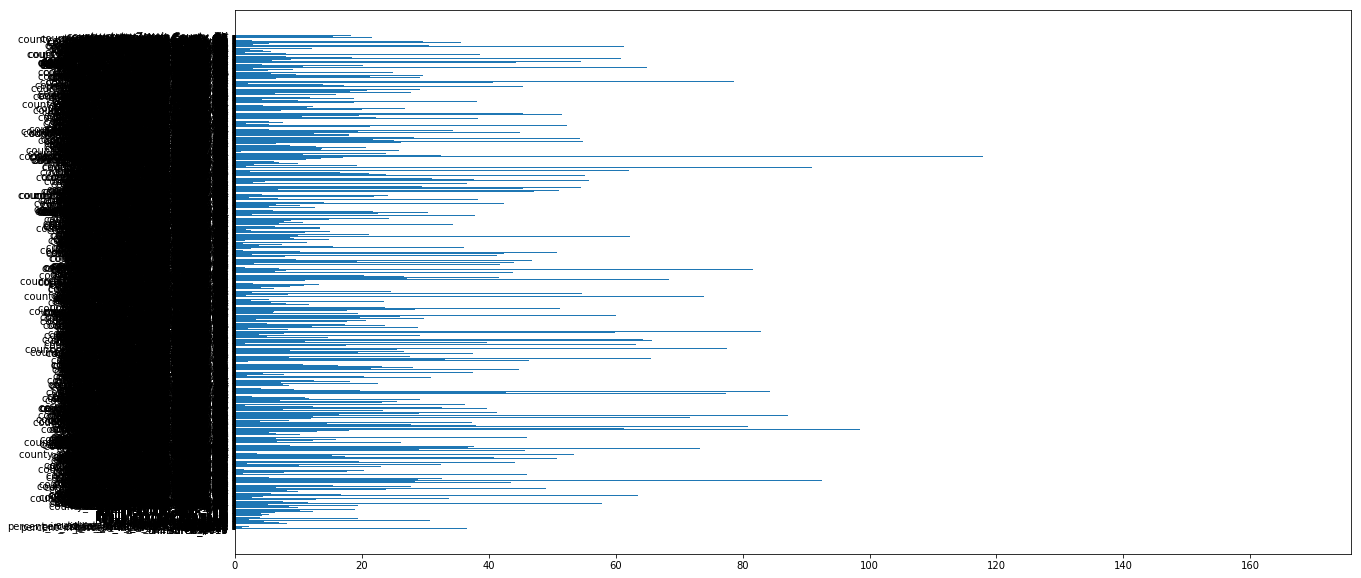

In [1136]:
coef_list = linreg.coef_.tolist()

impt_list_c = []
impt_list_f = []
for i in range(len(coef_list)): 
    if abs(coef_list[i]) > 1:
        impt_coef = abs(coef_list[i])
        impt_feat = X_train.columns[i]
        impt_list_c.append(impt_coef)
        impt_list_f.append(impt_feat)
        print(impt_coef, impt_feat)
        
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(impt_list_f, impt_list_c)